### 1. Importer les bibliothèques

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
import os


### 2. Chargement et préparation des données

In [3]:
def charger_donnees_departement(code):
    fichiers = [
        f"MENSQ_{code}_previous-1950-2023.csv",
        f"MENSQ_{code}_latest-2024-2025.csv"
    ]
    frames = []
    for f in fichiers:
        if os.path.exists(f):
            frames.append(pd.read_csv(f, delimiter=';', encoding='utf-8'))
        else:
            print(f"Fichier manquant : {f}")
    if not frames:
        raise FileNotFoundError(f"Aucun fichier trouvé pour {code} dans {dossier}")
    data = pd.concat(frames, ignore_index=True).drop_duplicates()
    data['date'] = pd.to_datetime(data['AAAAMM'], format='%Y%m', errors='coerce')
    data = data[data['date'] >= '1950-01-01']
    data['département'] = code
    return data

# Charger données
# departements = {
#     '79': 'data/deux_sevres',
#     '14': 'data/calvados',
#     '34': 'data/herault'
# }

departements = {
    '79': '',
    '14': '',
    '34': ''
}

frames = []
for code, dossier in departements.items():
    try:
        frames.append(charger_donnees_departement(code))
    except FileNotFoundError as e:
        print(e)
data = pd.concat(frames, ignore_index=True)

data['année'] = data['date'].dt.year
data['mois'] = data['date'].dt.month
data['amplitude_thermique'] = data['TM'] - data['TN']


In [63]:
import pandas as pd

def valeurs_manquantes_par_dep_triees(df):
    """
    Analyse les valeurs manquantes par département avec un tri décroissant
    
    Retourne:
        dict: {département: [(colonne, pourcentage), ...]} trié par % décroissant
    """
    resultats = {}
    
    for dep in df['département'].unique():
        # Filtrer le département
        df_dep = df[df['département'] == dep]
        
        # Calculer les pourcentages manquants
        manquants = df_dep.isna().mean().mul(100).round(2)
        
        # Supprimer les colonnes sans valeurs manquantes et trier
        manquants = manquants[manquants > 0]\
                      .sort_values(ascending=False)\
                      .items()
        
        # Stocker dans le résultat
        resultats[dep] = list(manquants)
    
    return resultats

# Application
manquants_tries = valeurs_manquantes_par_dep_triees(data)

# Affichage clair
for dep, variables in manquants_tries.items():
    print(f"\nDépartement {dep} - Variables avec valeurs manquantes:")
    print("-------------------------------------------")
    for var, pct in variables:
        print(f"{var}: {pct}%")
    print(f"\nTotal: {len(variables)} colonnes avec valeurs manquantes")


Département 79 - Variables avec valeurs manquantes:
-------------------------------------------
FXY: 100.0%
TN_ME: 100.0%
DXI3SAB: 100.0%
DIFT: 100.0%
QDIFT: 100.0%
DIRT: 100.0%
QDIRT: 100.0%
TX_ME: 100.0%
NEIGETOTABDAT: 99.51%
HNEIGEFDAT: 99.51%
HNEIGEFTOT: 99.15%
QHNEIGEFTOT: 99.15%
HNEIGEFAB: 99.15%
QHNEIGEFAB: 99.15%
NBJHNEIGEF1: 99.15%
NBJHNEIGEF5: 99.15%
NBJHNEIGEF10: 99.15%
RR_ME: 98.92%
NBJSOLNG: 98.84%
PMERMINAB: 98.8%
PMERMINABDAT: 98.8%
QPMERMINAB: 98.8%
QNEIGETOTAB: 98.23%
NBJNEIGETOT30: 98.23%
NBJNEIGETOT10: 98.23%
NBJNEIGETOT1: 98.23%
NEIGETOTAB: 98.23%
QNEIGETOTM: 98.23%
NEIGETOTM: 98.23%
QFXI3SAB: 98.12%
FXI3SAB: 98.12%
QDXI3SAB: 98.12%
FXI3SDAT: 98.12%
NBJFXI3S10: 98.12%
NBJFXI3S16: 98.12%
NBJFXI3S28: 98.12%
PMERM: 98.07%
QPMERM: 98.07%
QINST: 96.36%
NBSIGMA20: 96.36%
INST: 96.36%
NBSIGMA80: 96.36%
NBSIGMA0: 96.36%
QGLOT: 96.11%
GLOT: 96.11%
ETP: 95.83%
QETP: 95.83%
NBJGREL: 93.28%
DXYAB: 91.49%
NBJFXY8: 91.43%
FXYAB: 91.43%
NBJFXY15: 91.43%
NBJFXY10: 91.43%
QFXYAB: 9

### 3. Visualisation interactive : Températures annuelles

<Axes: >

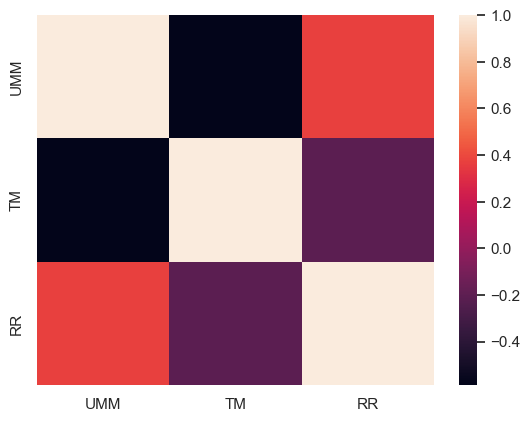

In [69]:
sns.heatmap(data[['UMM','TM','RR']].corr())

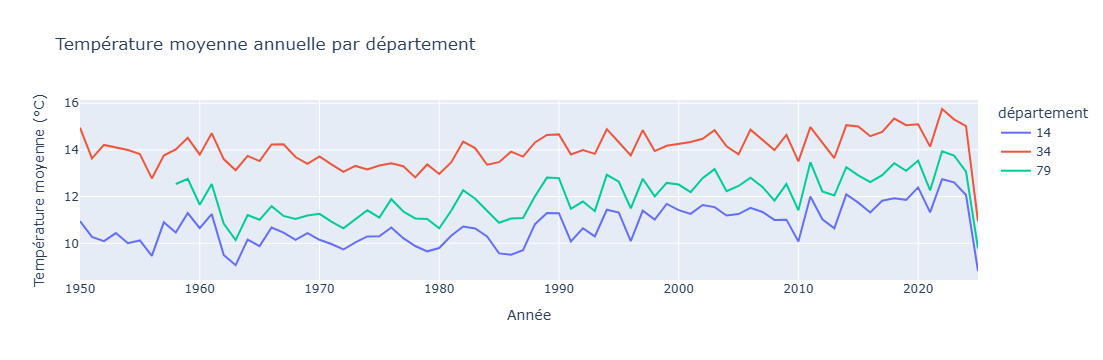

In [5]:
temp_annuelles = data.groupby(['département', 'année'])[['TM', 'TX', 'TN']].mean().reset_index()

fig = px.line(temp_annuelles, 
              x='année', 
              y='TM', 
              color='département', 
              title="Température moyenne annuelle par département",
              labels={'TM': 'Température moyenne (°C)', 'année': 'Année'})
fig.show()


### 4. Visualisation interactive : Précipitations annuelles

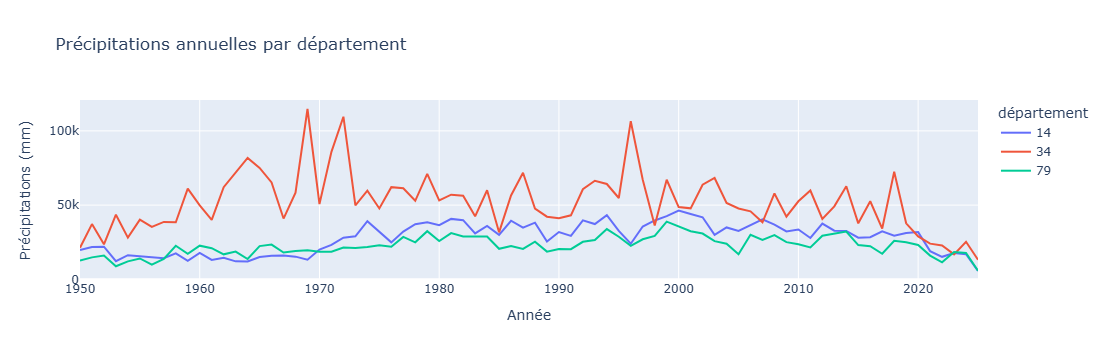

In [7]:
precip_annuelles = data.groupby(['département', 'année'])['RR'].sum().reset_index()

fig = px.line(precip_annuelles,
              x='année',
              y='RR',
              color='département',
              title="Précipitations annuelles par département",
              labels={'RR': 'Précipitations (mm)', 'année': 'Année'})
fig.show()


### 5. Visualisation : jours de fortes chaleurs

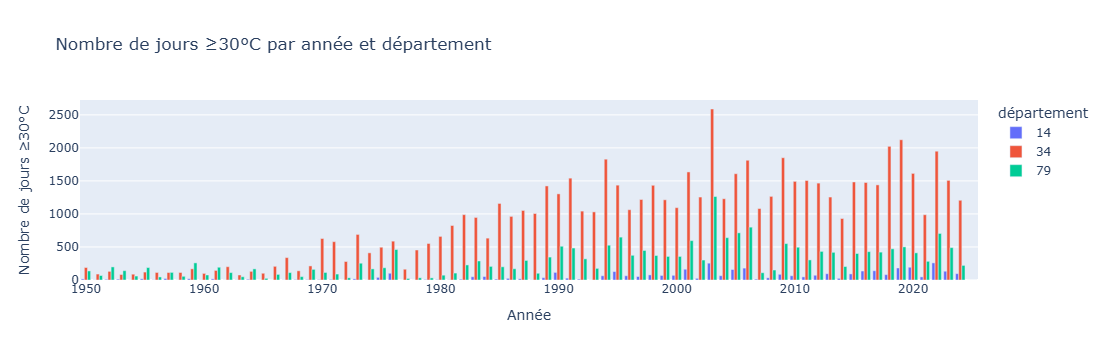

In [9]:
jours_chaleur = data.groupby(['département', 'année'])[['NBJTX30', 'NBJTX35']].sum().reset_index()

fig = px.bar(jours_chaleur, 
             x='année', 
             y='NBJTX30', 
             color='département', 
             barmode='group',
             title="Nombre de jours ≥30°C par année et département",
             labels={'NBJTX30': 'Nombre de jours ≥30°C', 'année': 'Année'})
fig.show()


### 6. Ajout d’éléments interactifs

In [11]:
import ipywidgets as widgets
from IPython.display import display

departement_widget = widgets.Dropdown(options=data['département'].unique(), description='Département:')
output = widgets.Output()

def update_graph(change):
    with output:
        output.clear_output()
        dep = change['new']
        df_filtre = temp_annuelles[temp_annuelles['département'] == dep]
        fig = px.line(df_filtre, x='année', y='TM', title=f"Température moyenne annuelle - Département {dep}")
        fig.show()

departement_widget.observe(update_graph, names='value')
display(departement_widget, output)

# Initial display
with output:
    dep = departement_widget.value
    df_filtre = temp_annuelles[temp_annuelles['département'] == dep]
    fig = px.line(df_filtre, x='année', y='TM', title=f"Température moyenne annuelle - Département {dep}")
    fig.show()


Dropdown(description='Département:', options=('79', '14', '34'), value='79')

Output()

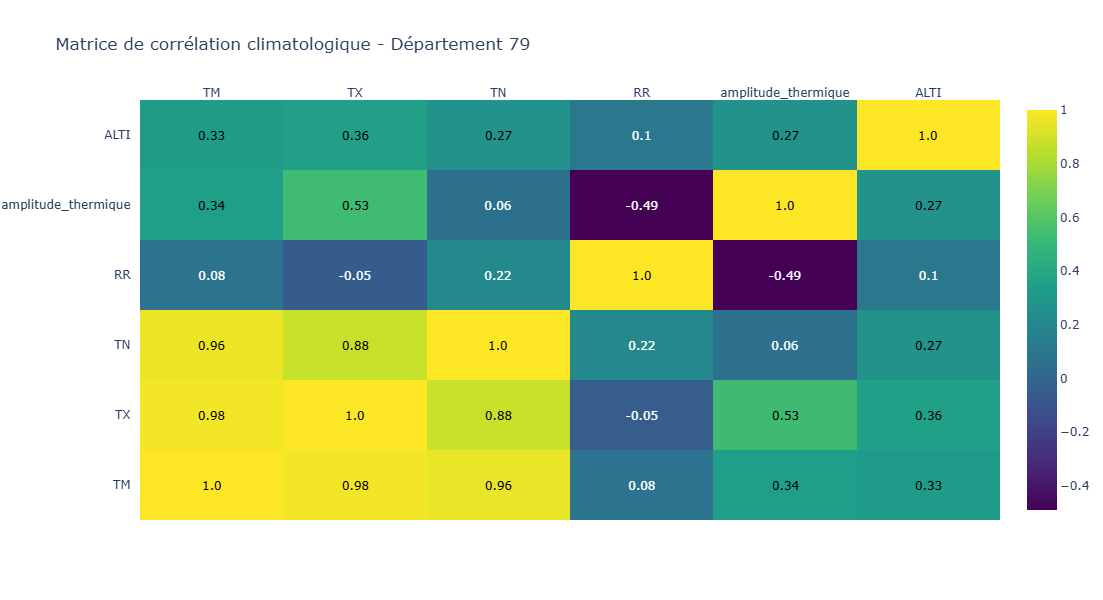

In [71]:
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px

# Liste des variables climatiques importantes selon ton dictionnaire
variables_comp = [
    'TM',           # Moyenne température
    'TX',           # Température max
    'TN',           # Température min
    'RR',           # Précipitations
    'amplitude_thermique',  # TX - TN, à calculer si pas encore fait
    # Pas de colonne 'grele', 'brouillard', 'neige', 'ensoleillement' dans ton dictionnaire, 
    # il faut adapter si tu as des équivalents dans tes fichiers ou les ajouter manuellement
    'ALTI'          # Altitude
]

# Calculer amplitude thermique si non calculée
if 'amplitude_thermique' not in data.columns:
    data['amplitude_thermique'] = data['TX'] - data['TN']

# Assurer que toutes les variables listées existent dans data (sinon création avec NaN)
for var in variables_comp:
    if var not in data.columns:
        data[var] = np.nan

# Calcul des moyennes annuelles par département
df_annuel = data.groupby(['département', 'année'])[variables_comp].mean().reset_index()

# Exemple : Matrice de corrélation interactive pour un département
dep_select = '79'  # à changer selon département à analyser
df_dep = df_annuel[df_annuel['département'] == dep_select]

corr = df_dep[variables_comp].corr()

fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    colorscale='Viridis',
    showscale=True,
    annotation_text=np.round(corr.values, 2),
    hoverinfo='z'
)

fig.update_layout(
    title_text=f"Matrice de corrélation climatologique - Département {dep_select}",
    height=600,
    width=700
)

fig.show()




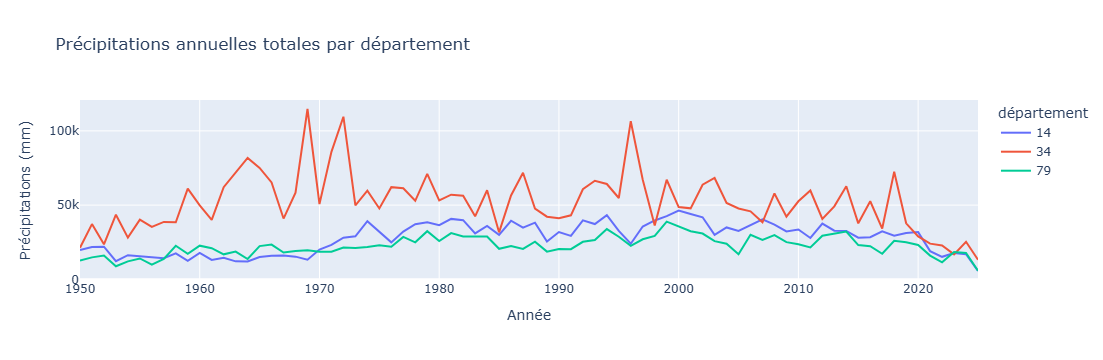

In [29]:
# Analyse des précipitations annuelles
precip_annuelles = data.groupby(['département', 'année'])[['RR']].sum().reset_index()

fig = px.line(precip_annuelles, 
              x='année', 
              y='RR', 
              color='département', 
              title="Précipitations annuelles totales par département",
              labels={'RR': 'Précipitations (mm)', 'année': 'Année'})
fig.show()

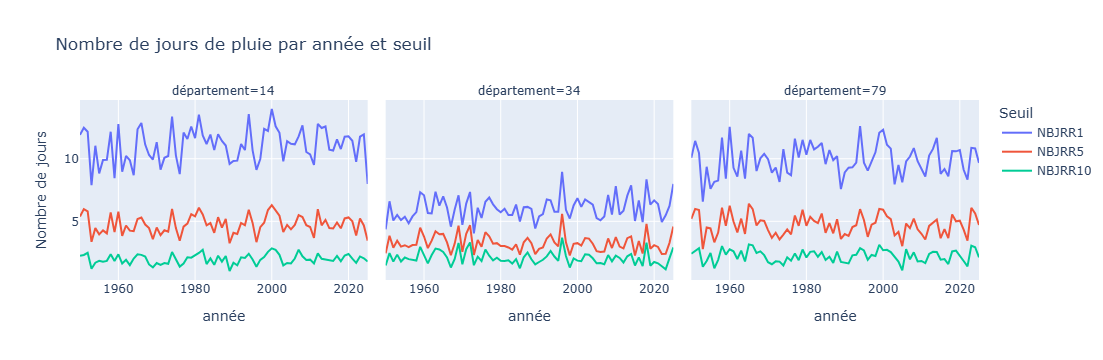

In [31]:
# Nombre de jours de pluie par an
jours_pluie = data.groupby(['département', 'année'])[['NBJRR1', 'NBJRR5', 'NBJRR10']].mean().reset_index()

fig = px.line(jours_pluie, 
              x='année', 
              y=['NBJRR1', 'NBJRR5', 'NBJRR10'], 
              facet_col='département',
              title="Nombre de jours de pluie par année et seuil",
              labels={'value': 'Nombre de jours', 'variable': 'Seuil'})
fig.show()

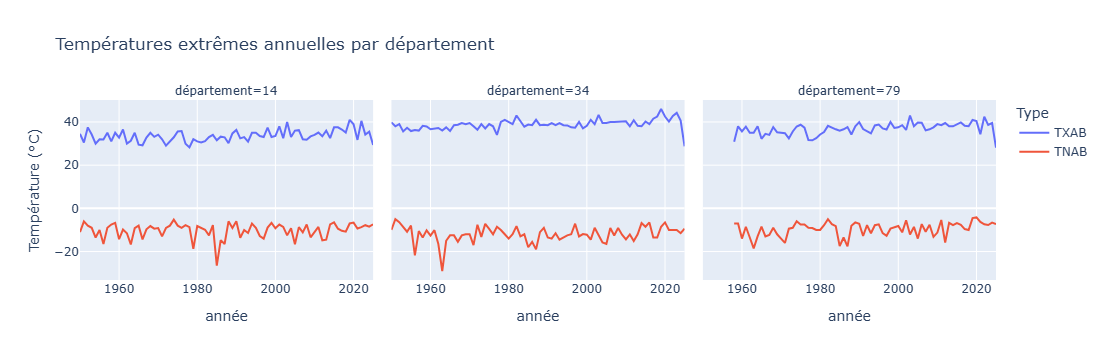

In [37]:
# Évolution des températures extrêmes
extremes_temp = data.groupby(['département', 'année']).agg({
    'TXAB': 'max',  # Température maximale absolue
    'TNAB': 'min'   # Température minimale absolue
}).reset_index()

fig = px.line(extremes_temp, 
              x='année', 
              y=['TXAB', 'TNAB'], 
              facet_col='département',
              title="Températures extrêmes annuelles par département",
              labels={'value': 'Température (°C)', 'variable': 'Type'})
fig.show()



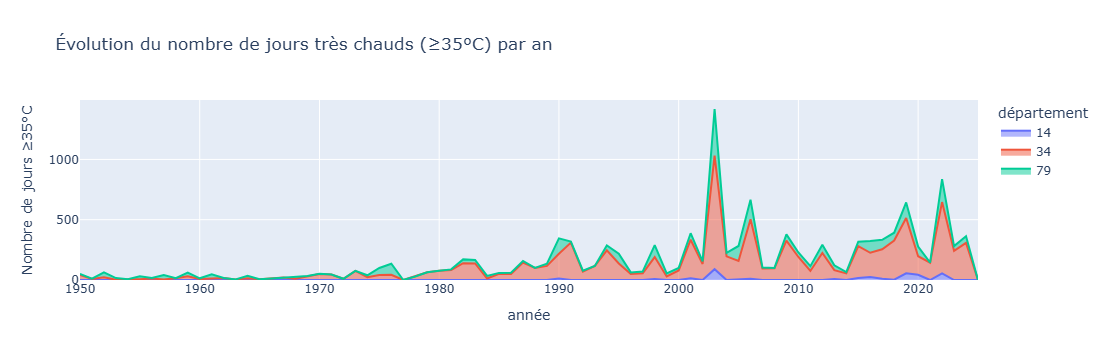

In [35]:
# Fréquence des vagues de chaleur
jours_chaleur = data.groupby(['département', 'année'])[['NBJTX30', 'NBJTX35']].sum().reset_index()

fig = px.area(jours_chaleur, 
              x='année', 
              y='NBJTX35', 
              color='département',
              title="Évolution du nombre de jours très chauds (≥35°C) par an",
              labels={'NBJTX35': 'Nombre de jours ≥35°C'})
fig.show()

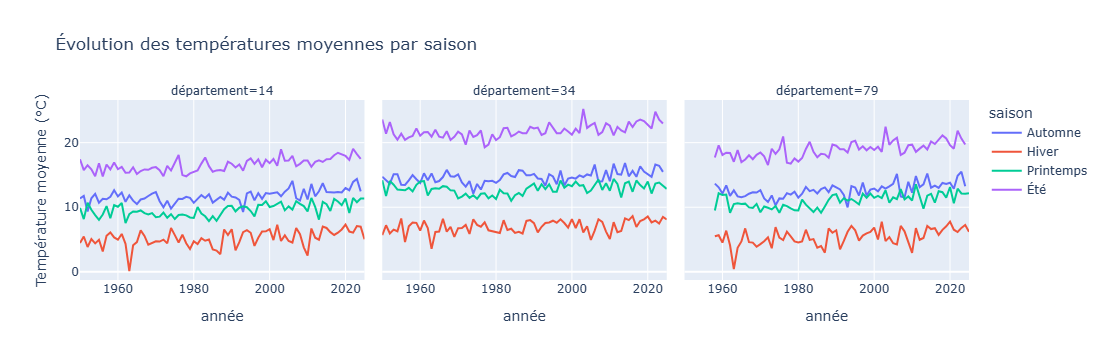

In [41]:
# Ajout d'une colonne saison
def get_season(month):
    if month in [12, 1, 2]:
        return 'Hiver'
    elif month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Été'
    else:
        return 'Automne'

data['saison'] = data['mois'].apply(get_season)

# Températures moyennes par saison
temp_saison = data.groupby(['département', 'année', 'saison'])['TM'].mean().reset_index()

fig = px.line(temp_saison, 
              x='année', 
              y='TM', 
              color='saison',
              facet_col='département',
              title="Évolution des températures moyennes par saison",
              labels={'TM': 'Température moyenne (°C)'})
fig.show()

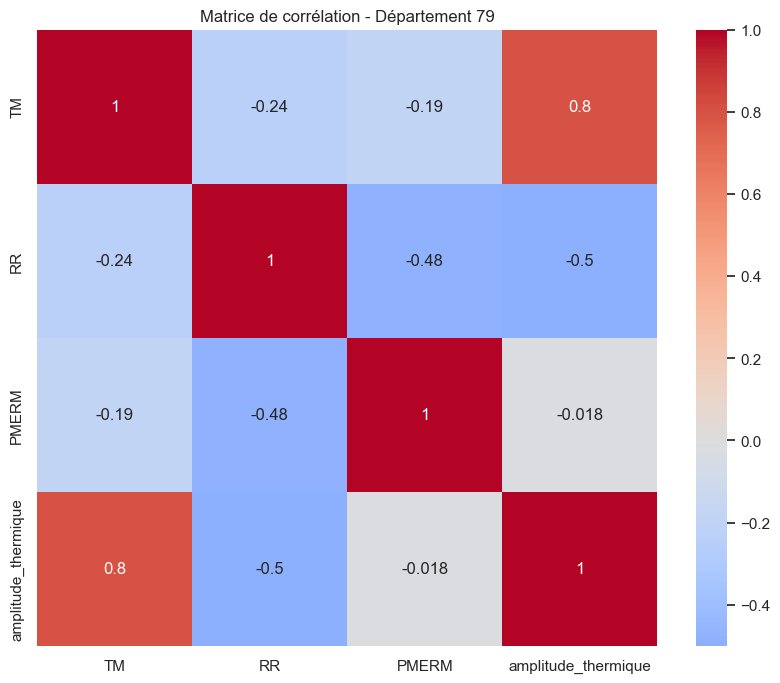

In [43]:
# Matrice de corrélation pour un département
dep = '79'
corr_data = data[data['département'] == dep][['TM', 'RR', 'PMERM', 'amplitude_thermique']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0)
plt.title(f"Matrice de corrélation - Département {dep}")
plt.show()

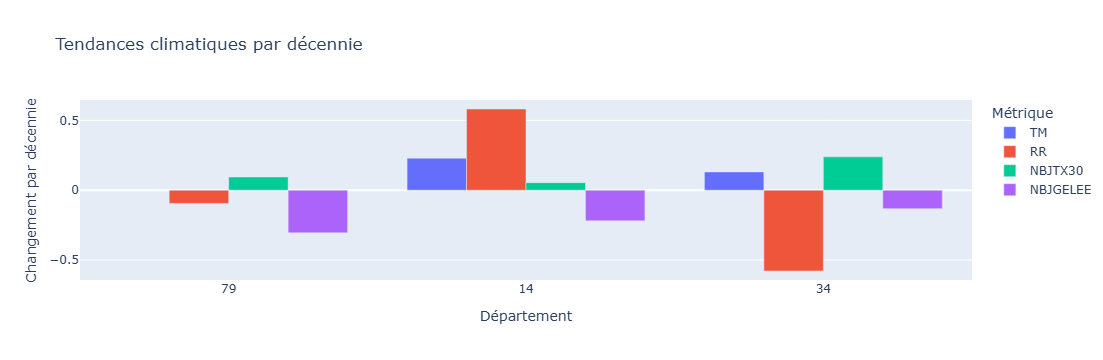

In [47]:
from scipy.stats import linregress

# Fonction pour calculer les tendances
def calculate_trend(df, y_col):
    x = df['année']
    y = df[y_col]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope * 10  # Tendance par décennie

# Calcul des tendances pour chaque département
tendances = []
for dep in data['département'].unique():
    df_dep = data[data['département'] == dep]
    for metric in ['TM', 'RR', 'NBJTX30', 'NBJGELEE']:
        trend = calculate_trend(df_dep.groupby('année')[metric].mean().reset_index(), metric)
        tendances.append({'Département': dep, 'Métrique': metric, 'Tendance': trend})

tendances_df = pd.DataFrame(tendances)

# Visualisation des tendances
fig = px.bar(tendances_df, 
             x='Département', 
             y='Tendance', 
             color='Métrique',
             barmode='group',
             title="Tendances climatiques par décennie",
             labels={'Tendance': 'Changement par décennie'})
fig.show()

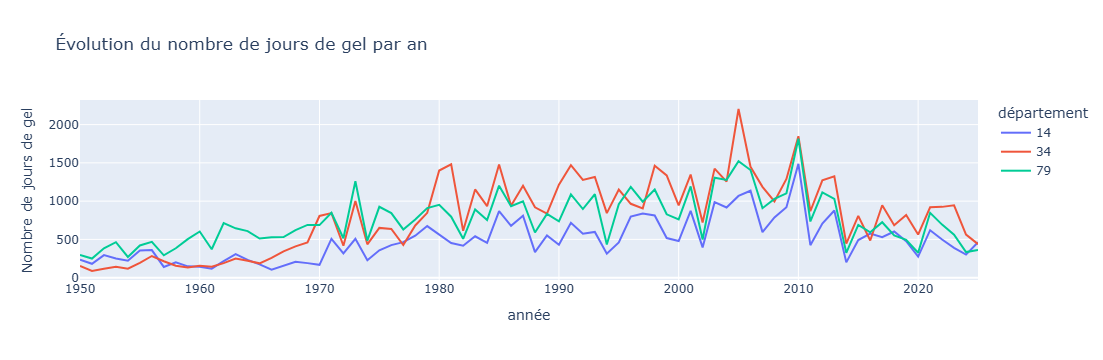

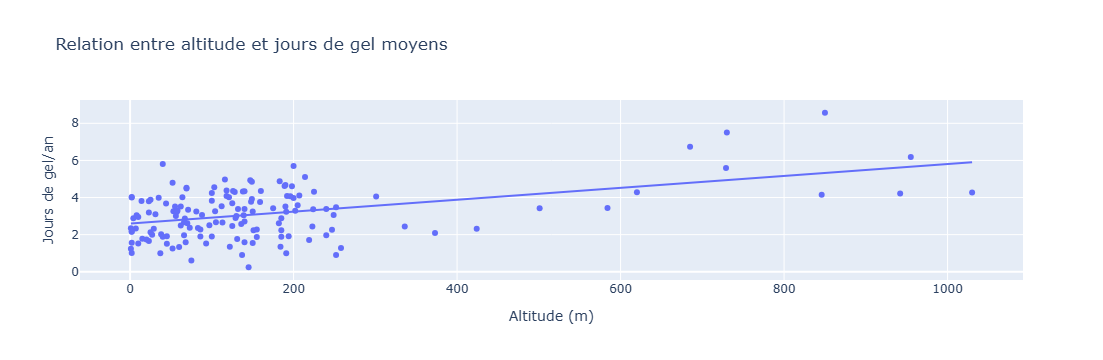

In [49]:
# Évolution des jours de gel
jours_gel = data.groupby(['département', 'année'])[['NBJGELEE']].sum().reset_index()

fig = px.line(jours_gel, 
              x='année', 
              y='NBJGELEE', 
              color='département',
              title="Évolution du nombre de jours de gel par an",
              labels={'NBJGELEE': 'Nombre de jours de gel'})
fig.show()



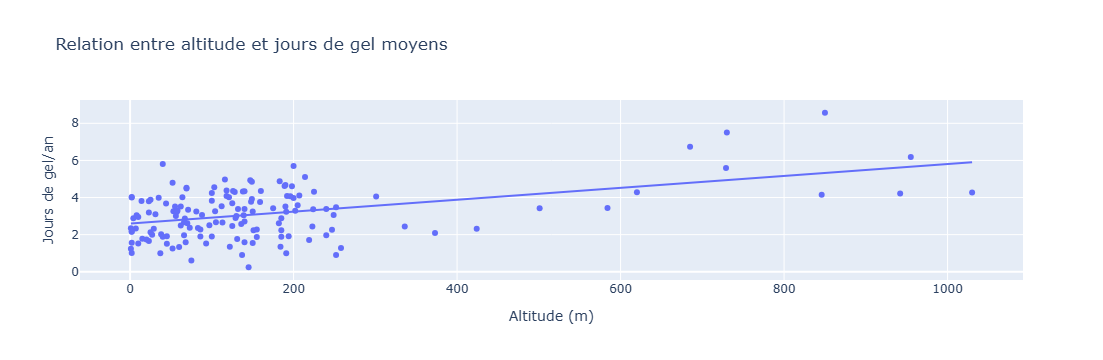

In [51]:
# Relation entre altitude et jours de gel
alti_gel = data.groupby(['NOM_USUEL', 'ALTI'])[['NBJGELEE']].mean().reset_index()

fig = px.scatter(alti_gel, 
                 x='ALTI', 
                 y='NBJGELEE', 
                 trendline="ols",
                 title="Relation entre altitude et jours de gel moyens",
                 labels={'ALTI': 'Altitude (m)', 'NBJGELEE': 'Jours de gel/an'})
fig.show()

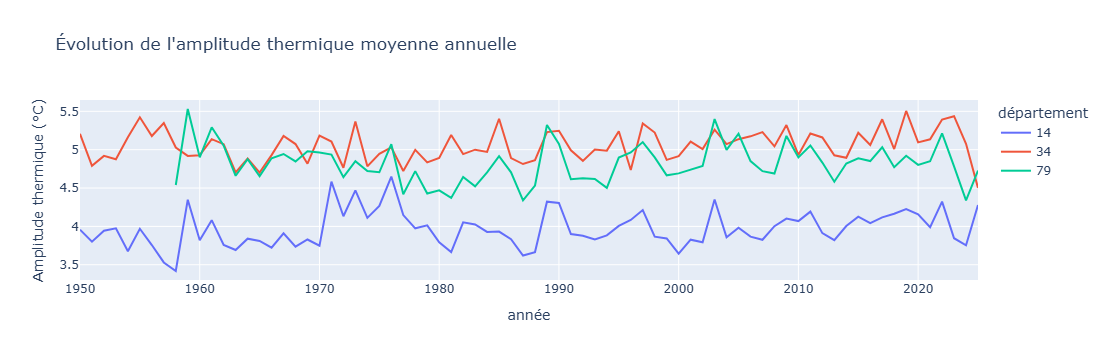

In [53]:
# Évolution de l'amplitude thermique annuelle
amplitude_annuelle = data.groupby(['département', 'année'])['amplitude_thermique'].mean().reset_index()

fig = px.line(amplitude_annuelle, 
              x='année', 
              y='amplitude_thermique', 
              color='département',
              title="Évolution de l'amplitude thermique moyenne annuelle",
              labels={'amplitude_thermique': 'Amplitude thermique (°C)'})
fig.show()



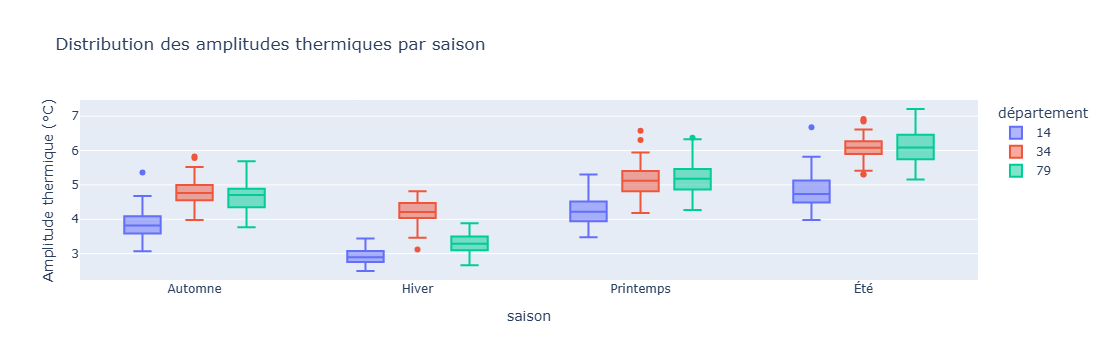

In [55]:
# Amplitude thermique par saison
amplitude_saison = data.groupby(['département', 'saison', 'année'])['amplitude_thermique'].mean().reset_index()

fig = px.box(amplitude_saison, 
             x='saison', 
             y='amplitude_thermique', 
             color='département',
             title="Distribution des amplitudes thermiques par saison",
             labels={'amplitude_thermique': 'Amplitude thermique (°C)'})
fig.show()

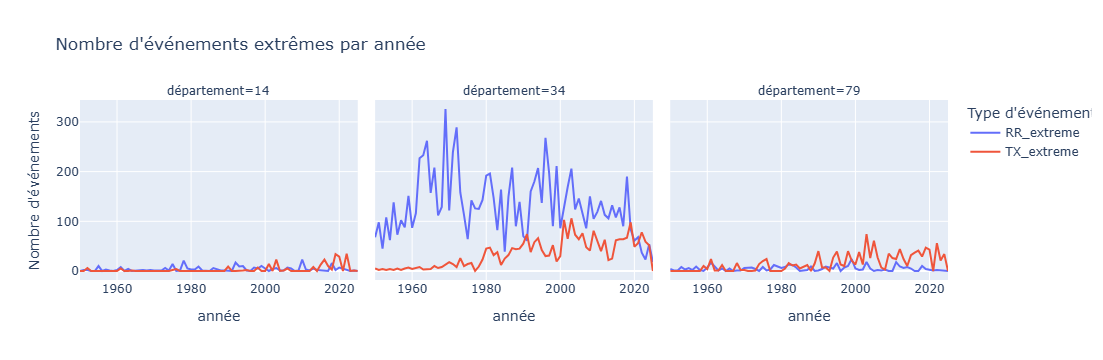

In [59]:
# Fréquence des événements extrêmes
data['RR_extreme'] = data['RRAB'] >= 50  # Précipitation extrême ≥ 50mm en 24h
data['TX_extreme'] = data['TXAB'] >= 35  # Journée extrêmement chaude ≥ 35°C

extreme_events = data.groupby(['département', 'année']).agg({
    'RR_extreme': 'sum',
    'TX_extreme': 'sum'
}).reset_index()

fig = px.line(extreme_events, 
              x='année', 
              y=['RR_extreme', 'TX_extreme'], 
              facet_col='département',
              title="Nombre d'événements extrêmes par année",
              labels={'value': "Nombre d'événements", 'variable': "Type d'événement"})
fig.show()